### **Imports and Configuration Setup**
Load all required Python libraries, suppress warnings

In [ ]:
## Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from scipy import stats
from scipy.stats import boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore')

### **Load Dataset**  
Mount Google Drive or use a local file path to import the salary dataset into a pandas DataFrame

In [55]:
# Load dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change the path accordingly
%cd /content/drive/MyDrive/UNF/PA/

# Load Local dataset
file_path = 'salary.xlsx'
df = pd.read_excel(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/UNF/PA


,job_title,salary_usd,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,education_required,years_experience,industry,benefits_score
0,AI Research Scientist,90376,SE,CT,China,M,China,50,Bachelor,9,Automotive,5.9
1,AI Software Engineer,61895,EN,CT,Canada,M,Ireland,100,Master,1,Media,5.2
2,AI Specialist,152626,MI,FL,Switzerland,L,South Korea,0,Associate,2,Education,9.4
3,NLP Engineer,80215,SE,FL,India,M,India,50,PhD,7,Consulting,8.6
4,AI Consultant,54624,EN,PT,France,S,Singapore,100,Master,0,Media,6.6


### **Preview the Dataset**  
Display the first few rows to understand the structure and content of the dataset

In [ ]:
# Print the dataSet
print(df)

                         job_title  salary_usd experience_level  \
0            AI Research Scientist       90376               SE   
1             AI Software Engineer       61895               EN   
2                    AI Specialist      152626               MI   
3                     NLP Engineer       80215               SE   
4                    AI Consultant       54624               EN   
...                            ...         ...              ...   
14995            Robotics Engineer       38604               EN   
14996  Machine Learning Researcher       57811               EN   
14997                 NLP Engineer      189490               EX   
14998                   Head of AI       79461               EN   
14999     Computer Vision Engineer       56481               MI   

      employment_type company_location company_size employee_residence  \
0                  CT            China            M              China   
1                  CT           Canada         

### **Missing Value Check**  
Identify any null values across columns to assess data completeness

In [ ]:
# Detect missing values
print("=== Missing Values ===")
print(df.isnull().sum())

=== Missing Values ===
job_title             0
salary_usd            0
experience_level      0
employment_type       0
company_location      0
company_size          0
employee_residence    0
remote_ratio          0
education_required    0
years_experience      0
industry              0
benefits_score        0
dtype: int64


### **Duplicate Row Detection**  
Verify whether the dataset contains duplicate records that need to be handled

In [ ]:
# Detect Duplicate values
print("\n=== Duplicate Rows ===")
print(f"Number of duplicate rows: {df.duplicated().sum()}")


=== Duplicate Rows ===
Number of duplicate rows: 0


### **Outlier Detection Using IQR Method**  
Detect and count outliers in key numerical columns (`salary_usd`, `years_experience`, and `benefits_score`) using the Interquartile Range (IQR) technique

In [ ]:
# Detect outliers using IQR for numerical columns
numerical_cols = ['salary_usd', 'years_experience', 'benefits_score']

print("\n=== Outlier Detection ===")
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Number of outliers in {col}: {len(outliers)}")


=== Outlier Detection ===
Number of outliers in salary_usd: 483
Number of outliers in years_experience: 0
Number of outliers in benefits_score: 0


### **Convert Remote Ratio to Categorical Labels**  
Map numeric remote work ratios to categorical labels (`OnSite`, `Hybrid`, `FullTime`) for better interpretation and modeling

In [ ]:
# Convert remote_ratio to categorical
# Map remote_ratio values to labels
remote_ratio_mapping = {0: 'OnSite', 50: 'Hybrid', 100: 'FullTime'}
df['remote_ratio'] = df['remote_ratio'].map(remote_ratio_mapping)

print("\n=== Updated Categorical Values ===")
print(df['remote_ratio'].unique())


=== Updated Categorical Values ===
['Hybrid' 'FullTime' 'OnSite']


### **Identify and Display Original Categorical Variables**  
Separate `salary_usd` as the dependent variable and list all original categorical features in the dataset

In [ ]:
# Setting salary_usd as dependent variable and others as independent variables
X = df.drop('salary_usd', axis=1)  # Independent variables
y = df['salary_usd']  # Dependent variable

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("\n=== Original Categorical Values ===")
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")


=== Original Categorical Values ===
job_title: ['AI Research Scientist' 'AI Software Engineer' 'AI Specialist'
 'NLP Engineer' 'AI Consultant' 'AI Architect' 'Principal Data Scientist'
 'Data Analyst' 'Autonomous Systems Engineer' 'AI Product Manager'
 'Machine Learning Engineer' 'Data Engineer' 'Research Scientist'
 'ML Ops Engineer' 'Robotics Engineer' 'Head of AI'
 'Deep Learning Engineer' 'Data Scientist' 'Machine Learning Researcher'
 'Computer Vision Engineer']
experience_level: ['SE' 'EN' 'MI' 'EX']
employment_type: ['CT' 'FL' 'PT' 'FT']
company_location: ['China' 'Canada' 'Switzerland' 'India' 'France' 'Germany'
 'United Kingdom' 'Singapore' 'Austria' 'Sweden' 'South Korea' 'Norway'
 'Netherlands' 'United States' 'Israel' 'Australia' 'Ireland' 'Denmark'
 'Finland' 'Japan']
company_size: ['M' 'L' 'S']
employee_residence: ['China' 'Ireland' 'South Korea' 'India' 'Singapore' 'Germany'
 'United Kingdom' 'France' 'Austria' 'Sweden' 'Norway' 'Israel'
 'United States' 'Netherlands' '

### **Apply One-Hot Encoding to Categorical Features**  
Encode all identified categorical variables using one-hot encoding and update the dataset for compatibility with regression models

In [ ]:
# One-hot encoding for all categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Update X after encoding
# set the boolean columns to int for compatibility with regression models
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
X_encoded = df_encoded.drop('salary_usd', axis=1)

print("\n=== Encoded Categorical Values ===")
for col in df_encoded.columns:
    print(f"{col}: {df_encoded[col].unique()}")


=== Encoded Categorical Values ===
salary_usd: [ 90376  61895 152626 ... 189490  79461  56481]
years_experience: [ 9  1  2  7  0  3  5  8 15  6  4 16 10 18 12 19 17 13 11 14]
benefits_score: [ 5.9  5.2  9.4  8.6  6.6  6.3  7.6  9.3  5.8  9.9  6.8  9.1  9.8  9.6
  8.7  6.7 10.   6.9  7.4  8.8  7.7  6.   9.2  5.3  5.7  7.9  6.1  8.1
  8.   5.1  7.5  5.5  5.4  9.7  7.2  5.6  9.   6.2  6.5  7.1  9.5  7.
  8.2  8.4  7.8  6.4  8.3  8.9  7.3  8.5  5. ]
job_title_AI Consultant: [0 1]
job_title_AI Product Manager: [0 1]
job_title_AI Research Scientist: [1 0]
job_title_AI Software Engineer: [0 1]
job_title_AI Specialist: [0 1]
job_title_Autonomous Systems Engineer: [0 1]
job_title_Computer Vision Engineer: [0 1]
job_title_Data Analyst: [0 1]
job_title_Data Engineer: [0 1]
job_title_Data Scientist: [0 1]
job_title_Deep Learning Engineer: [0 1]
job_title_Head of AI: [0 1]
job_title_ML Ops Engineer: [0 1]
job_title_Machine Learning Engineer: [0 1]
job_title_Machine Learning Researcher: [0 1]
job_t

### **Random Forest Feature Importance**  
Train a Random Forest model to evaluate and visualize the importance of different features in predicting `salary_usd`

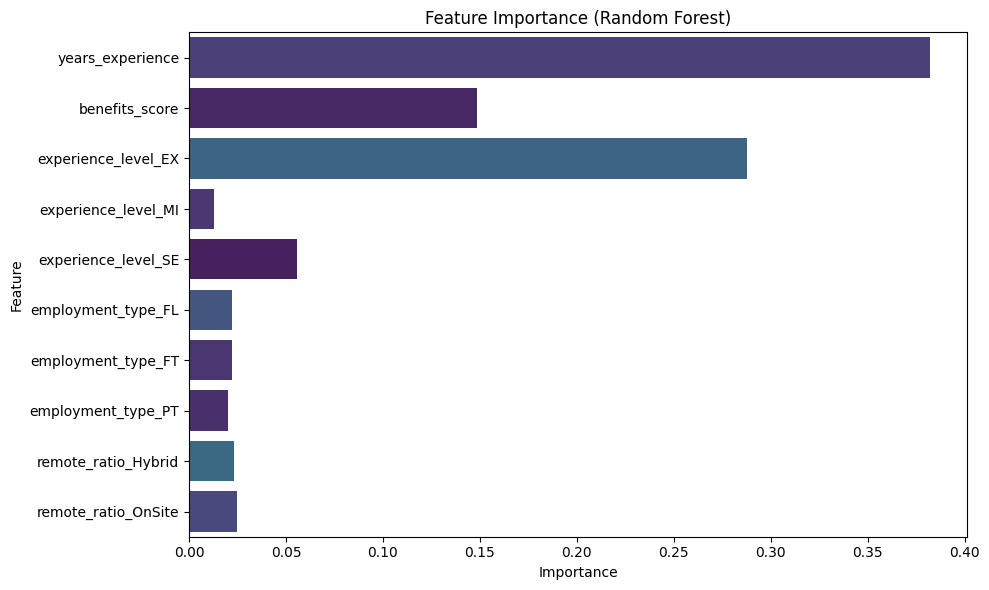

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Prepare data
X = pd.get_dummies(df[['experience_level', 'employment_type', 'remote_ratio',
                      'years_experience', 'benefits_score']], drop_first=True)
y = df['salary_usd']

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X, y)

importances = model_rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', hue=df['salary_usd'], palette='viridis', legend=False)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

### **Correlation Heatmap of Encoded Features**  
Visualize the correlation matrix for all encoded features to identify multicollinearity and key associations

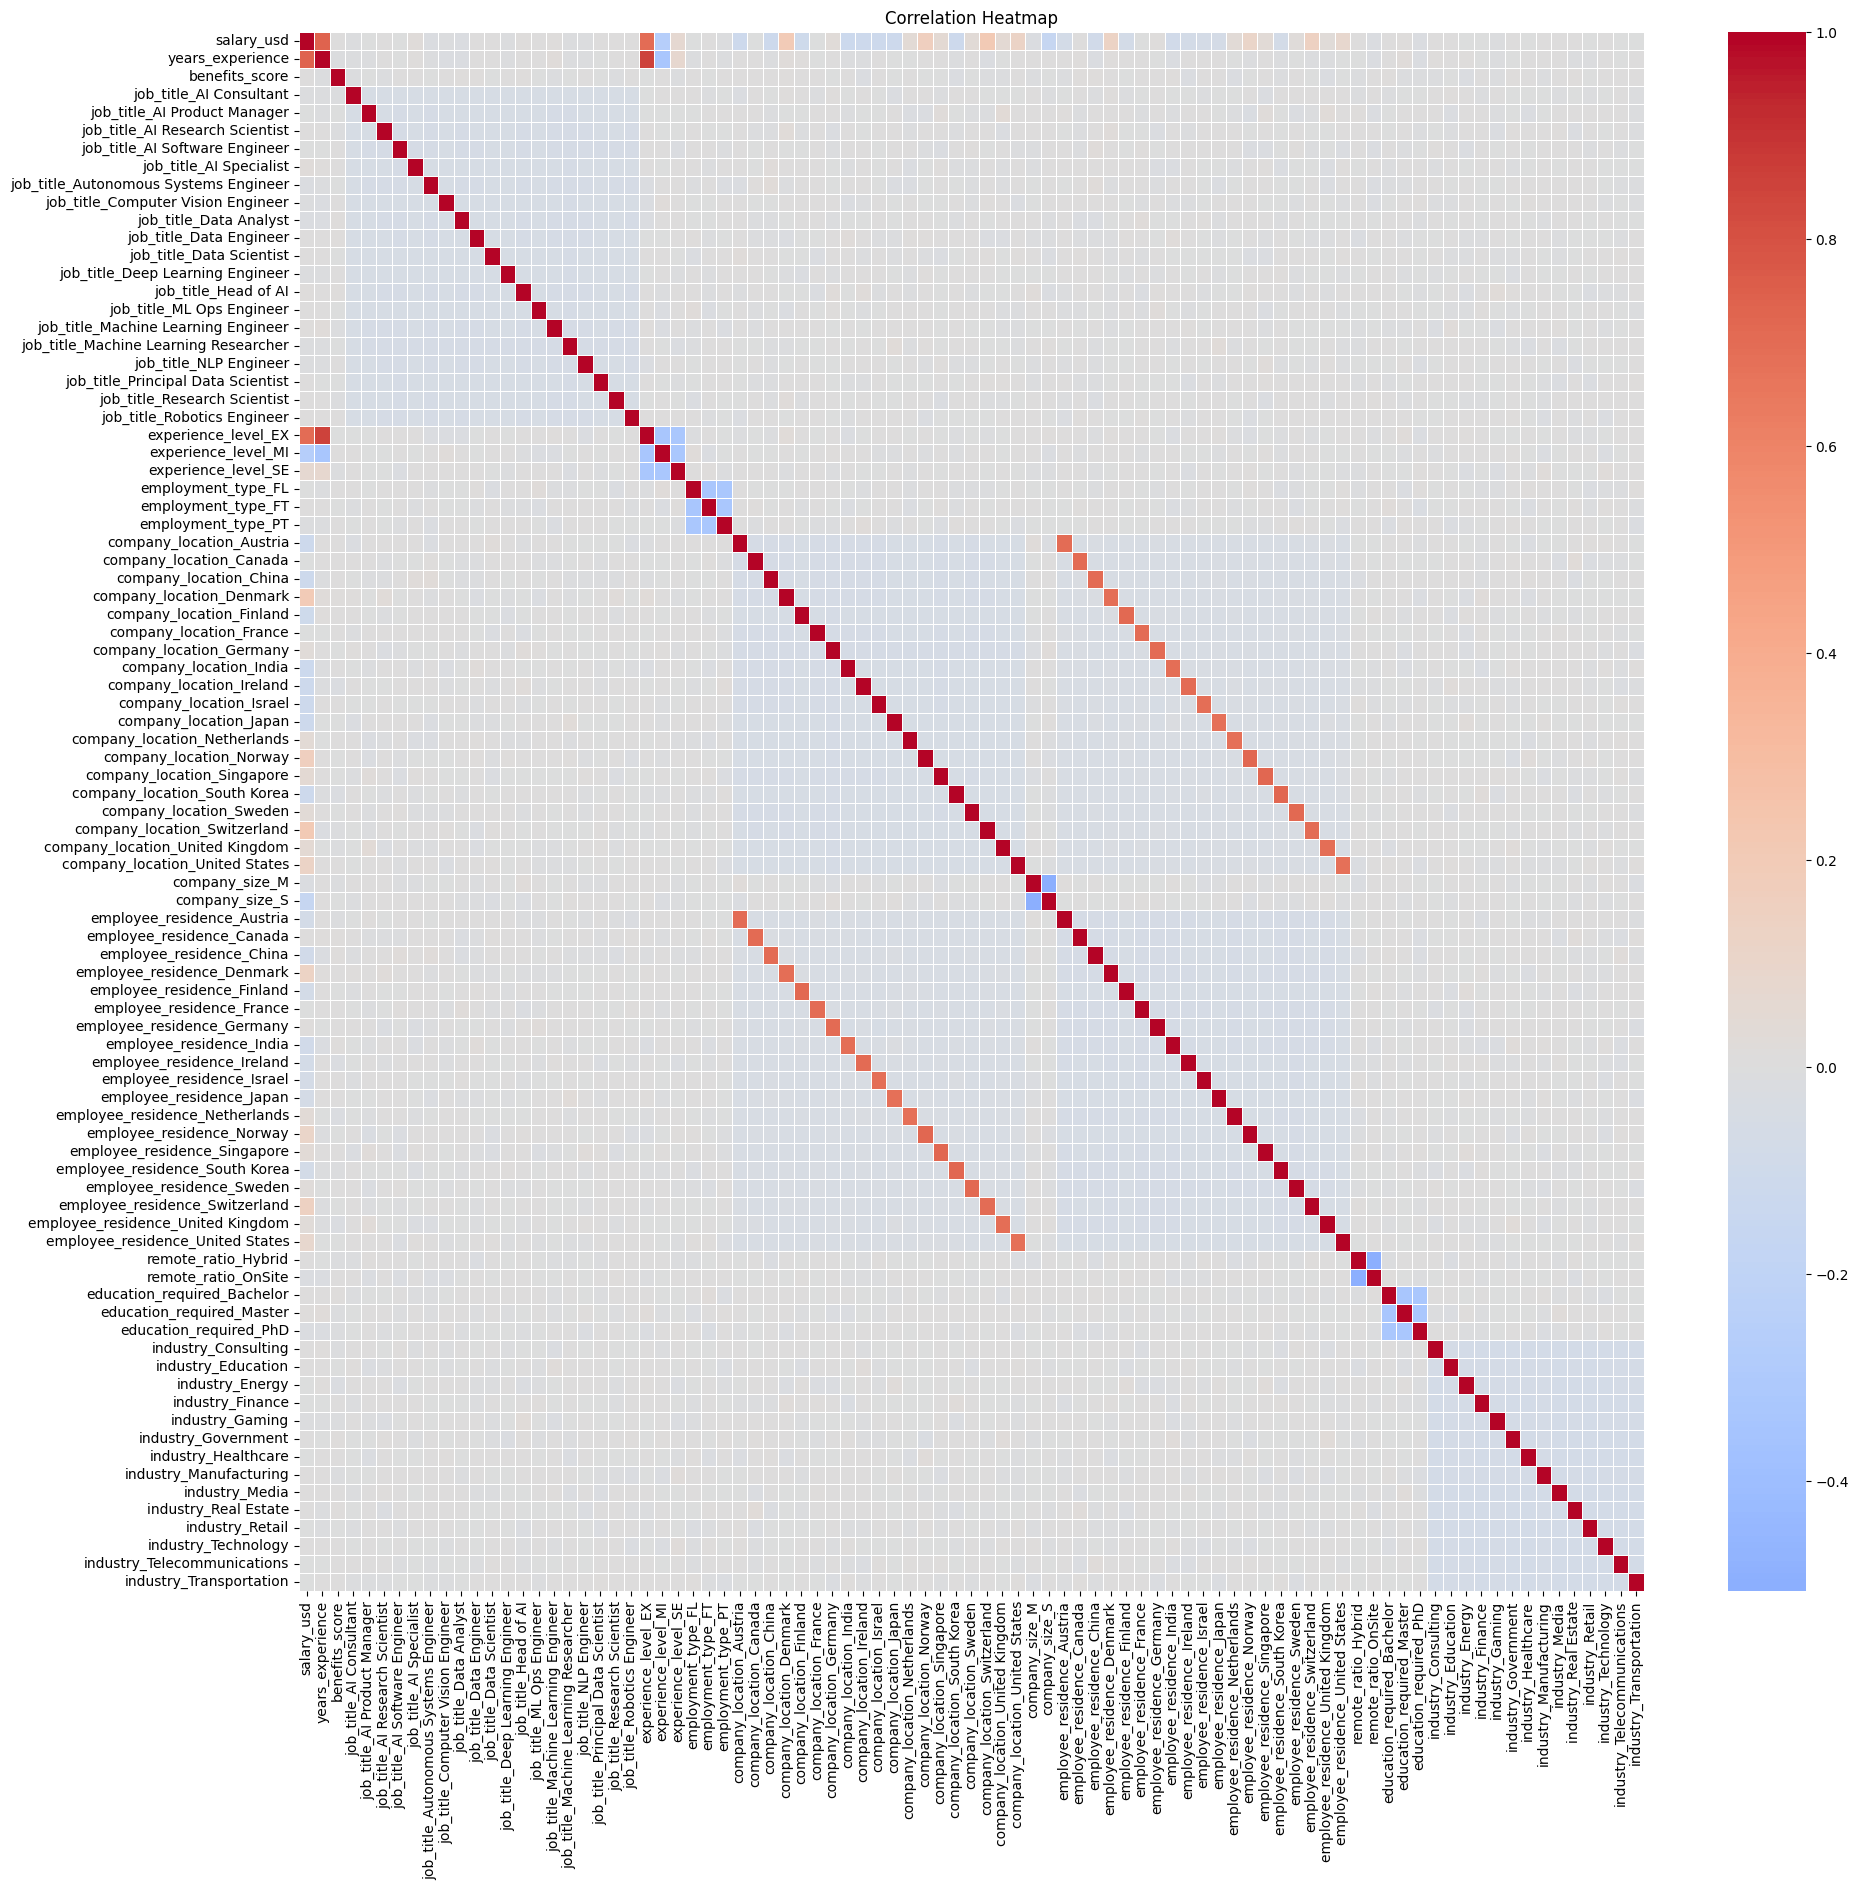

In [51]:
corr_matrix = df_encoded.corr()
plt.figure(figsize=(20, 19))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()
plt.close()

### **Display Correlation Matrix**  
Output the full numeric correlation matrix to explore linear relationships between variables

In [62]:
df_encoded.corr()

,salary_usd,years_experience,benefits_score,job_title_AI Consultant,job_title_AI Product Manager,job_title_AI Research Scientist,job_title_AI Software Engineer,job_title_AI Specialist,job_title_Autonomous Systems Engineer,job_title_Computer Vision Engineer,...,industry_Gaming,industry_Government,industry_Healthcare,industry_Manufacturing,industry_Media,industry_Real Estate,industry_Retail,industry_Technology,industry_Telecommunications,industry_Transportation
salary_usd,1.000000,0.737556,0.000985,-0.006176,-0.002531,0.009745,-0.004192,0.019571,-0.015330,-0.007012,...,-0.010322,0.001530,-0.004052,0.003536,0.003537,0.002538,-0.002624,0.002154,-0.000255,-0.002263
years_experience,0.737556,1.000000,-0.007275,-0.006153,-0.006877,0.006241,-0.001108,0.012569,-0.006929,-0.012133,...,-0.008608,-0.002976,0.001427,0.003897,0.008991,-0.011191,-0.008908,0.001823,-0.003303,0.000268
benefits_score,0.000985,-0.007275,1.000000,-0.009040,-0.000524,-0.009374,0.000754,0.007118,-0.000917,0.002188,...,-0.006892,0.011918,0.002498,-0.005985,0.006991,0.016782,-0.000706,0.006521,0.005136,0.006888
job_title_AI Consultant,-0.006176,-0.006153,-0.009040,1.000000,-0.050659,-0.051124,-0.052113,-0.050119,-0.051867,-0.049974,...,0.007208,-0.002327,-0.004799,-0.002766,-0.007485,-0.000330,-0.006007,-0.003080,0.002793,-0.007330
job_title_AI Product Manager,-0.002531,-0.006877,-0.000524,-0.050659,1.000000,-0.052593,-0.053610,-0.051559,-0.053357,-0.051410,...,-0.007380,-0.003001,-0.016510,-0.000817,0.003907,0.002603,0.006401,0.008483,0.005693,-0.010342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
industry_Real Estate,0.002538,-0.011191,0.016782,-0.000330,0.002603,-0.013094,0.004031,0.005116,0.009421,0.007949,...,-0.070420,-0.071619,-0.071581,-0.070225,-0.073410,1.000000,-0.074087,-0.072118,-0.071581,-0.071581
industry_Retail,-0.002624,-0.008908,-0.000706,-0.006007,0.006401,0.006442,-0.009992,0.002913,0.001098,0.004476,...,-0.072497,-0.073731,-0.073692,-0.072296,-0.075574,-0.074087,1.000000,-0.074244,-0.073692,-0.073692
industry_Technology,0.002154,0.001823,0.006521,-0.003080,0.008483,-0.004806,0.001384,-0.003795,-0.000444,-0.007193,...,-0.070570,-0.071772,-0.071733,-0.070375,-0.073566,-0.072118,-0.074244,1.000000,-0.071733,-0.071733
industry_Telecommunications,-0.000255,-0.003303,0.005136,0.002793,0.005693,0.009483,-0.006145,-0.002974,-0.010439,-0.002650,...,-0.070045,-0.071237,-0.071199,-0.069851,-0.073018,-0.071581,-0.073692,-0.071733,1.000000,-0.071199


### **Apply Salary Transformations**  
Create new salary columns using linear, log, square root, and Box-Cox transformations for regression modeling

In [ ]:
# Create a copy of the original dataframe for transformations
df_transformed = df.copy()

# Linear regression
df_transformed['salary_linear'] = df_transformed['salary_usd']

# Log transformation
df_transformed['salary_log'] = np.log(df_transformed['salary_usd'])

# Square root transformation
df_transformed['salary_sqrt'] = np.sqrt(df_transformed['salary_usd'])

# Box-Cox transformation
df_transformed['salary_boxcox'], _ = boxcox(df_transformed['salary_usd'] + 1)  # +1 to handle zeros if any

### **Run Regression with Transformed Targets**  
Train and evaluate linear regression models for each salary transformation to assess performance

In [ ]:
# Run regression with transformed targets
transformations = {
    'linear': df_transformed['salary_linear']
}

for name, y_transformed in transformations.items():
    # Need to re-encode X for each transformation since we're using df_transformed
    X_transformed = df_transformed.drop(['salary_usd', 'salary_log', 'salary_sqrt', 'salary_boxcox'], axis=1)
    X_transformed['remote_ratio'] = X_transformed['remote_ratio'].astype('object')
    X_trans_encoded = pd.get_dummies(X_transformed, columns=categorical_cols, drop_first=True)

    bool_cols = X_trans_encoded.select_dtypes(include='bool').columns
    X_trans_encoded[bool_cols] = X_trans_encoded[bool_cols].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X_trans_encoded, y_transformed, test_size=0.2, random_state=42)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    if name == 'linear':
      print(f"\n{name.capitalize()}:")
    else:
      print(f"\n{name.capitalize()} Transformation:")

    print(f"R-squared: {r2_score(y_test, y_pred):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")

    X_train_encoded = sm.add_constant(X_encoded)  # Add intercept
    model = sm.OLS(y_transformed, X_train_encoded).fit()
    print(model.summary())

### **Compare Skewness and Visualize Salary Distributions**  
Compare skewness statistics and use histograms to visualize the effect of each transformation on salary distribution


=== Skewness Comparison ===
Original skewness: 1.253
Log transform skewness: 0.139
Sqrt transform skewness: 0.677
Box-Cox transform skewness: 0.012


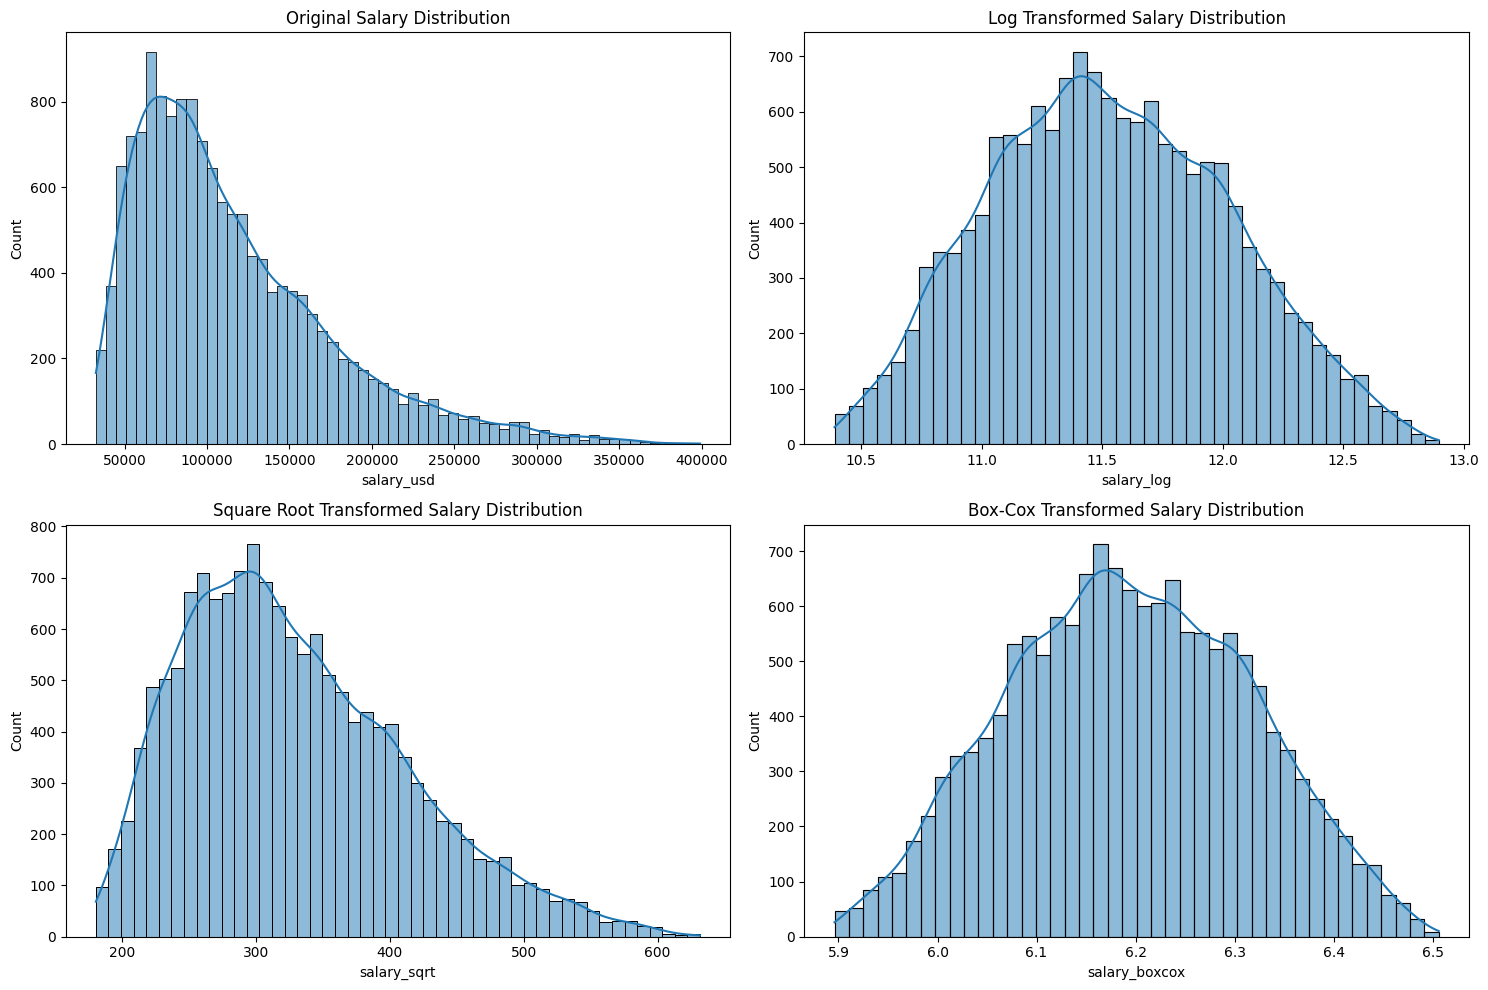

In [52]:
# Compare skewness
print("\n=== Skewness Comparison ===")
print(f"Original skewness: {df_transformed['salary_usd'].skew():.3f}")
print(f"Log transform skewness: {df_transformed['salary_log'].skew():.3f}")
print(f"Sqrt transform skewness: {df_transformed['salary_sqrt'].skew():.3f}")
print(f"Box-Cox transform skewness: {df_transformed['salary_boxcox'].skew():.3f}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(df_transformed['salary_usd'], kde=True)
plt.title('Original Salary Distribution')

plt.subplot(2, 2, 2)
sns.histplot(df_transformed['salary_log'], kde=True)
plt.title('Log Transformed Salary Distribution')

plt.subplot(2, 2, 3)
sns.histplot(df_transformed['salary_sqrt'], kde=True)
plt.title('Square Root Transformed Salary Distribution')

plt.subplot(2, 2, 4)
sns.histplot(df_transformed['salary_boxcox'], kde=True)
plt.title('Box-Cox Transformed Salary Distribution')

plt.tight_layout()
plt.show()
plt.close()

### **Run Regression for Log, Sqrt, and Box-Cox Targets**  
Loop through each transformation and evaluate model performance using R-squared and Mean Squared Error

In [59]:
# Run regression with transformed targets
transformations = {
    'log': df_transformed['salary_log'],
    'sqrt': df_transformed['salary_sqrt'],
    'boxcox': df_transformed['salary_boxcox']
}

print("\n=== Regression with Transformed Targets ===")
for name, y_transformed in transformations.items():
    # Need to re-encode X for each transformation since we're using df_transformed
    X_transformed = df_transformed.drop(['salary_usd', 'salary_log', 'salary_sqrt', 'salary_boxcox'], axis=1)
    X_transformed['remote_ratio'] = X_transformed['remote_ratio'].astype('object')
    X_trans_encoded = pd.get_dummies(X_transformed, columns=categorical_cols, drop_first=True)

    bool_cols = X_trans_encoded.select_dtypes(include='bool').columns
    X_trans_encoded[bool_cols] = X_trans_encoded[bool_cols].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X_trans_encoded, y_transformed, test_size=0.2, random_state=42)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    if name == 'linear':
      print(f"\n{name.capitalize()}:")
    else:
      print(f"\n{name.capitalize()} Transformation:")

    print(f"R-squared: {r2_score(y_test, y_pred):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")

    X_train_encoded = sm.add_constant(X_encoded)  # Add intercept
    model = sm.OLS(y_transformed, X_train_encoded).fit()
    print(model.summary())


=== Regression with Transformed Targets ===

Log Transformation:
R-squared: 0.967
Mean Squared Error: 0.0081
                            OLS Regression Results                            
Dep. Variable:             salary_log   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     2024.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:07:47   Log-Likelihood:                 8290.0
No. Observations:               15000   AIC:                        -1.641e+04
Df Residuals:                   14913   BIC:                        -1.574e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0

### **Compare Model Performance Metrics**  
Build a summary table comparing R-squared and RMSE across all regression models

In [58]:
# Function to fit and evaluate model
def evaluate_model(X_train, X_test, y_train, y_test, model_name):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return model, r2, rmse


X = X_encoded
y = df_transformed['salary_linear']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 1. Original
model_orig, r2_orig, rmse_orig = evaluate_model(X_train, X_test, y_train, y_test, 'Original')

# 2. Log Transformation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
model_log, r2_log, rmse_log = evaluate_model(X_train, X_test, y_train_log, y_test_log, 'Log')

# 3. Square Root Transformation
y_train_sqrt = np.sqrt(y_train)
y_test_sqrt = np.sqrt(y_test)
model_sqrt, r2_sqrt, rmse_sqrt = evaluate_model(X_train, X_test, y_train_sqrt, y_test_sqrt, 'Sqrt')

# 4. Box-Cox Transformation
y_train_boxcox, lambda_boxcox = boxcox(y_train)
y_test_boxcox = boxcox(y_test, lmbda=lambda_boxcox)
model_boxcox, r2_boxcox, rmse_boxcox = evaluate_model(X_train, X_test, y_train_boxcox, y_test_boxcox, 'Box-Cox')

# Results
results_df = pd.DataFrame({
    'Model': ['Original', 'Log', 'Sqrt', 'Box-Cox'],
    'R-squared': [r2_orig, r2_log, r2_sqrt, r2_boxcox],
    'RMSE': [rmse_orig, rmse_log, rmse_sqrt, rmse_boxcox]
})

print("\n=== Model Performance Summary ===")
print(results_df)


=== Model Performance Summary ===
      Model  R-squared          RMSE
0  Original   0.852304  23209.390499
1       Log   0.920248      0.140016
2      Sqrt   0.900451     26.360071
3   Box-Cox   0.920420      0.033264


## **Generate Residual and Q-Q Diagnostic Plots for Model Evaluation**
Create Residual plots and Q-Q plots for different model transformations (Original, Log, Square Root, Box-Cox).

These diagnostics help to assess:
- **Linearity and homoscedasticity** via residuals vs. fitted plots
- **Normality of residuals** via Q-Q plots

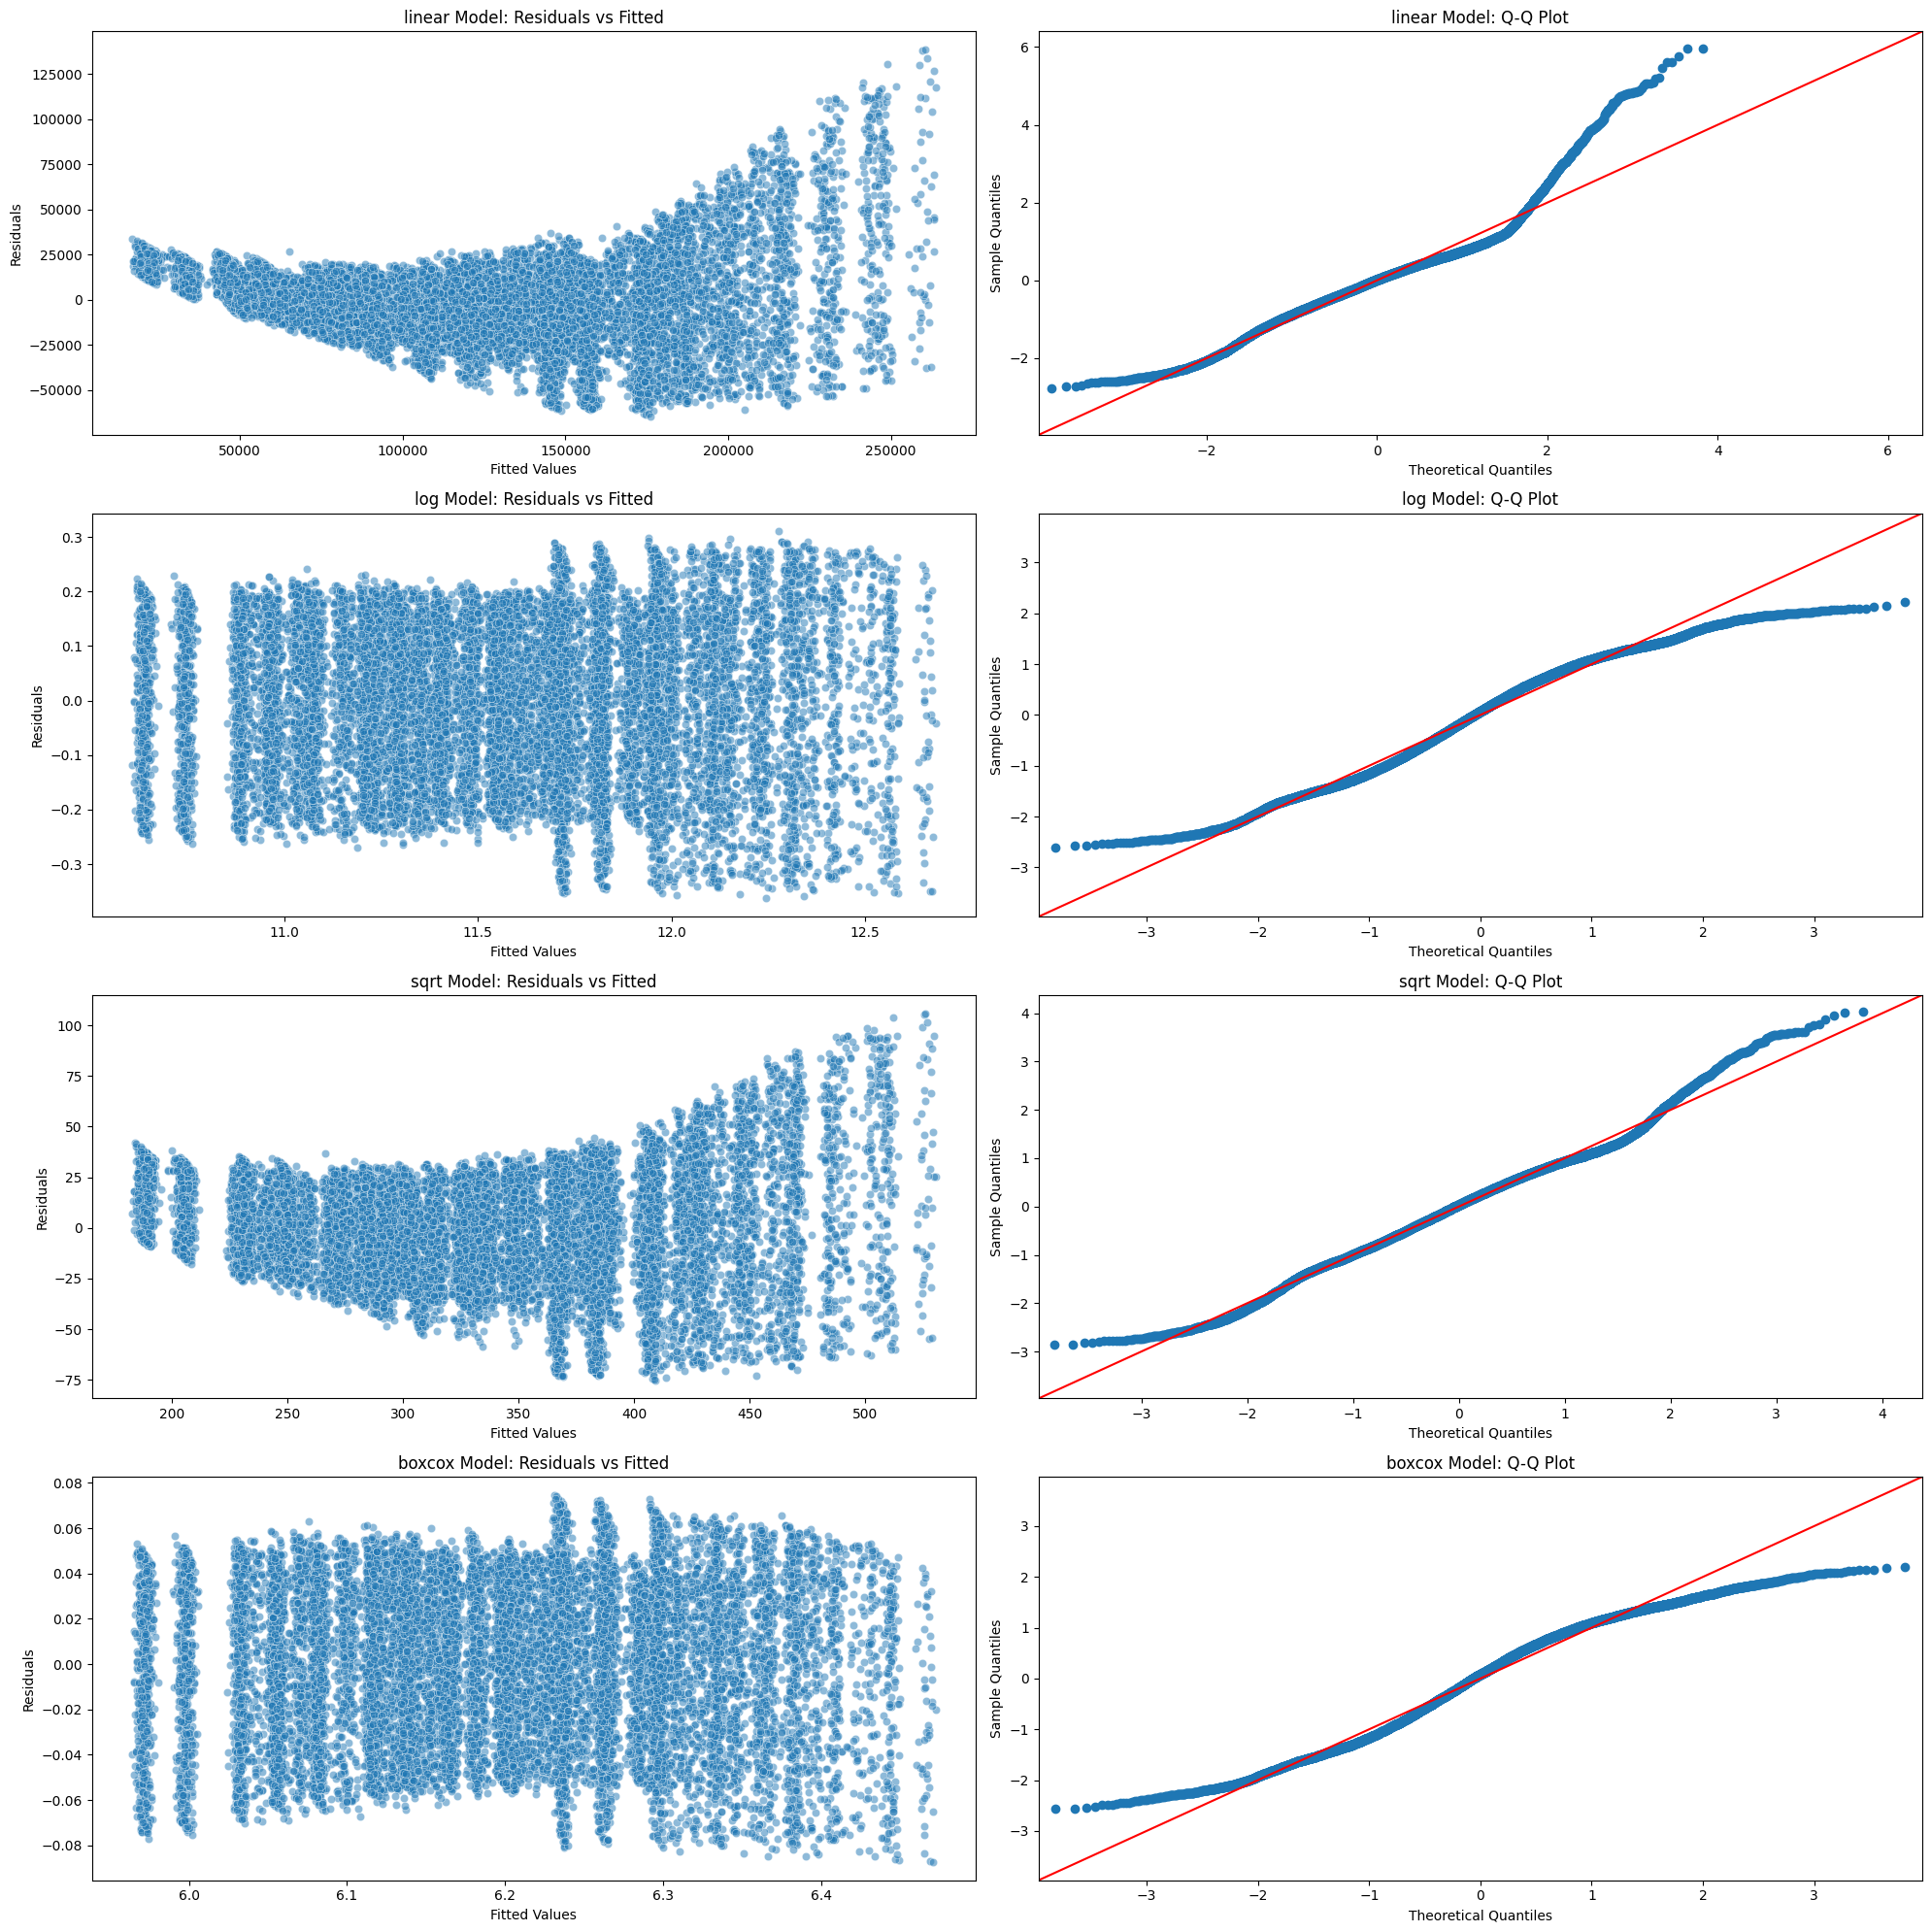

In [56]:
# Create diagnostic plots for both models
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

transformationss = {
    'linear': df_transformed['salary_linear'],
    'log': df_transformed['salary_log'],
    'sqrt': df_transformed['salary_sqrt'],
    'boxcox': df_transformed['salary_boxcox']
}

# Loop through transformed target variables to evaluate residuals
for idx, val in enumerate(transformationss.items()):

    name, y_transformed = val
    # Add intercept to predictors
    X_train_encoded = sm.add_constant(X_encoded)

    # Fit model using statsmodels
    model = sm.OLS(y_transformed, X_train_encoded).fit()

    # Residual vs Fitted Plot
    residuals = model.resid
    fitted = model.fittedvalues
    sns.scatterplot(x=fitted, y=residuals, alpha=0.5, ax=axes[idx, 0])
    axes[idx, 0].set_xlabel('Fitted Values')
    axes[idx, 0].set_ylabel('Residuals')
    axes[idx, 0].set_title(f'{name} Model: Residuals vs Fitted')

    sm.graphics.qqplot(residuals, line='45', fit=True, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{name} Model: Q-Q Plot')

plt.tight_layout()
plt.show()